# Einfärbung Knoten

Warnungen des Systems deaktivieren.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Verwendete Bibliotheken einladen.

In [3]:
from shapely.geometry import *
import osmnx as ox
import networkx as nx
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial import Voronoi
from shapely import wkt

## Kreise in SH als GDF einladen

In [4]:
kreise = gpd.read_file('./Daten/Bevoelkerung/Gemeindegrenzen_SH_2021_mit_Einwohnerzahl.geojson')

## Netzwerkgraphen in SH einladen

Sofern bereits ein Netzwerkgraph besteht, diesen einladen. Existiert noch kein Graph, muss dieser erst erstellt werden.

In [5]:
G = ox.graph_from_xml('./Daten/osm/gesamtgraph.osm', simplify=False)
G = ox.project_graph(G, to_crs='EPSG:25832')

Die Reisezeiten für die Kanten hinzufügen, um diese später als Gewichtung für die Berechnung der Fahrzeit zu haben.

In [6]:
# Iteriere durch jede Kante im Graphen
for u, v, data in G.edges(data=True):
    # Konvertiere 'maxspeed' von String zu Float
    maxspeed = float(data['maxspeed'])

    # Berechne die Zeit in Minuten und füge sie als 'time' zum Kantenattribut hinzu
    data['time'] = (data['length'] / maxspeed) * (60 / 1000)


## Polygon definieren zum Verkleinern

Da der Gesamtgraph für die Berechnung zu lang braucht, muss der Graph verkleinert werden. Dafür wird ein Polygon (BBox) definiert, auf welche der Graph zugeschnitten werden soll.

In [7]:
# Beispiel-Koordinaten für ein Polygon (als Beispiel) 
polygon_coords = [(497898, 6042991), (497898, 6032731), (518417, 6032731), (518417, 6042991)]

Graph auf die BBox zuschneiden. Nur Knoten und Kanten verwendet, die in dieser liegen.

In [8]:
# Erstellen einr Shapely-Polygon aus den gegebenen Koordinaten
polygon = Polygon(polygon_coords)

# Filteren der Knoten und Kanten des Graphen basierend auf dem Polygon
nodes_in_polygon = [node for node, data in G.nodes(data=True) if polygon.contains(Point(data['x'], data['y']))]

# Überprüfen, ob 'geometry' in den Kanten vorhanden ist, bevor darauf zugegriffen wird
edges_in_polygon = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) if 'geometry' in data and data['geometry'].intersects(polygon)]

# Erstellen eines neuen Graphen basierend auf den ausgewählten Knoten und Kanten
subgraph = G.subgraph(nodes_in_polygon + list(set([u for u, v, k in edges_in_polygon] + [v for u, v, k in edges_in_polygon])))

## Ärzte einladen 

In [9]:
aerzte = gpd.read_file('./Daten/Aerzte/aerzte_general_sh.geojson')

GDF mit den Ärzten ebenfalls verkleinern und auf die BBox zuschneiden.

In [10]:
import geopandas as gpd
from shapely.geometry import Polygon

polygon_coordinates =  [(497898, 6042991), (497898, 6032731), (518417, 6032731), (518417, 6042991)]
polygon_geometry = Polygon(polygon_coordinates)

# Erstellen eins GeoDataFrame für das Polygon
polygon_gdf = gpd.GeoDataFrame(geometry=[polygon_geometry])

# Filtern der Punkte innerhalb des Polygons
points_in_polygon = aerzte[aerzte.geometry.within(polygon_geometry)]


Das gleiche gilt für die Kreise. Auch sie werden zugeschnitten.

In [11]:
kreise_klein = kreise[kreise.geometry.intersects(polygon_geometry)]

Kanten und Knoten aus dem verkleinerten Graphen extrahieren.

In [12]:
edges = ox.graph_to_gdfs(subgraph, nodes=False)
gdf_nodes = ox.graph_to_gdfs(subgraph, edges=False)

## Voronoi Polygone

Zur Zurodnung der Knoten zum nächstgelegenen Arzt werden Voronoi-Polygone erstellt. Dafür wird zuerst ein Puffer um die umgrenzende Geometrie des Untersuchungsbereich gelegt und viele Punkte auf der Grenze (alle 100 Meter) interpoliert. Dadurch werden die Formen der Voronoi-Polygone leicht vergrößert.  

In [14]:
import shapely

a = shapely.unary_union(kreise_klein['geometry'])
b = a.buffer(2000).envelope.boundary
# Punkte im 100-Meter-Abstand um das Untersuchungsgebiet interpolieren.
boundarypoints = [b.interpolate(distance=d) for d in range(0, np.ceil(b.length).astype(int), 100)]
boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])

Die Koordinaten der Ärzte innerhalb der BBox in einem Array ablegen.

In [17]:
coords = np.stack([points_in_polygon.geometry.x, points_in_polygon.geometry.y], axis=1)

Zusammenfügen der Koordinaten der Ärzte und der interpolierten Knoten auf der Genze des Untersuchungsgebiet.

In [18]:
all_coords = np.concatenate((boundarycoords, coords)) #Create an array of all points on the boundary and inside the polygon

Erstellen der Voronoi-Polygonen ausgehend von den Ärzten innerhalb der BBox und den interpolierten Punkten.

In [19]:
vor = Voronoi(points=all_coords)
lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]

polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:25832")

polydf = gpd.GeoDataFrame(geometry=[a], crs="epsg:25832") #Geodataframe aus dem zusammengeführtem GDF kreise_klein
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=coords[:,0], y=coords[:,1], crs="epsg:25832")) # muss nicht, da das gleiche wie points_in_polygon (kleiner Layer der Ärzte)

voronoi_polygons = gpd.overlay(df1=voronois, df2=polydf, how="intersection")

Visualisierung der Voronoi-Polygone in Rot. 

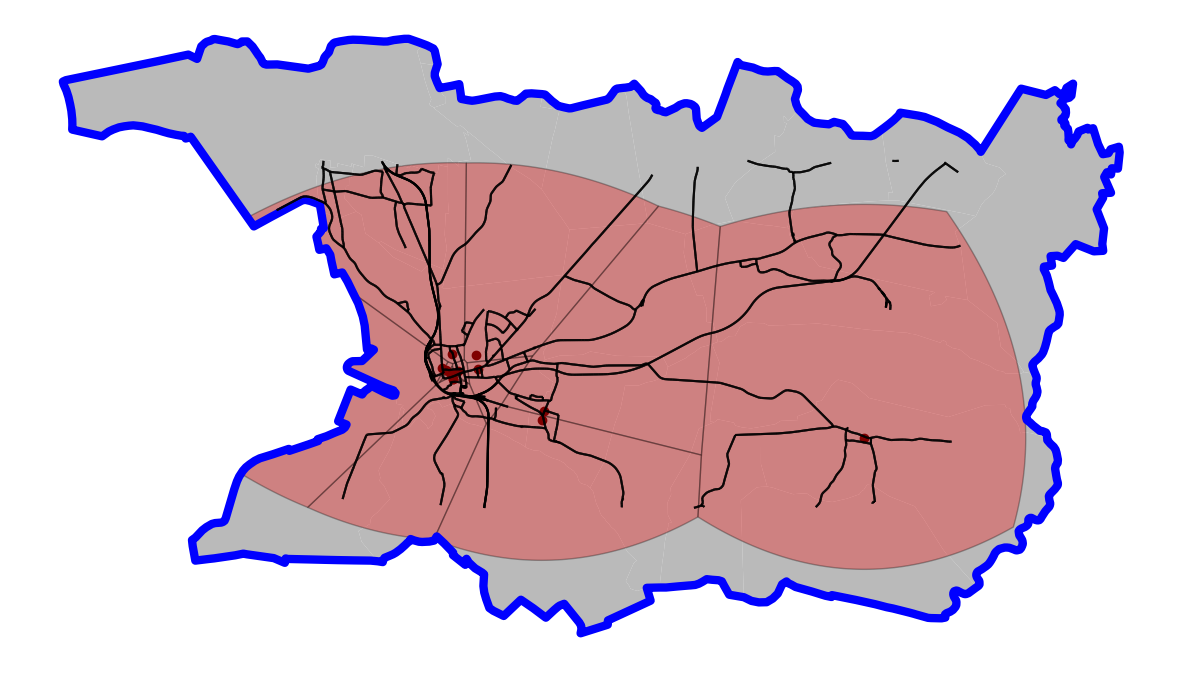

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
kreise_klein.plot(ax=ax, color="darkgrey", alpha=0.8)
polydf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6)
voronoi_polygons.plot(ax=ax, color="red", alpha=0.3, edgecolor="black")
edges.plot(ax=ax, color='black',alpha=0.5)
points_in_polygon.plot(ax=ax, color="maroon")

ax.set_axis_off()

Den Voronoi-Polgonen wird ein Index hinzugefügt, der dann auf die Knoten übertragen wird. Liegt der Knoten im Voronoi-Polygon mit dem Index 1, wird der Index 1 auf den Knoten übertragen. Das gleiche wird mit den Standorten der Ärzte bzw. dem verkleinerten GDF points_in_polygon gemacht. So können Knoten und Ärzte nach dem index_right zusammengefügt werden und jeder Knoten besitzt die Informationen ink. der Geometrien des nächstgelegenen Arztes. Dies wird in einem neuen GDF final_result gespeichert.

In [21]:
# Hinzufügen einer eindeutige ID zu den Voronoi-Polygone
voronoi_polygons['voronoi_id'] = voronoi_polygons.index

# Spatial Join zwischen den Punkten und den Voronoi-Polygonen
joined = gpd.sjoin(gdf_nodes, voronoi_polygons, how="left", op="within")

joined_arzt_vor = gpd.sjoin(points_in_polygon, voronoi_polygons, how="left", op="within")

# Hier wird 'joined' ein neues GeoDataFrame sein, das die Knoten sowie die Informationen der zugehörigen Voronoi-Polygone enthält.

#Informationen der Ärzte zu den Punkten hinzufügen
final_result = pd.merge(joined, joined_arzt_vor, how='left', left_on='index_right', right_on='index_right')

Für jeden Knoten wird nun die Reisezeit zum hinzugefügten Arzt über Dijkstra berechnet. Sollte dies zu lange dauern, existiert der Beispieldatensatz bereits. Dann kann dieser optional eingelesen werden und die Berechnung übersprungen werden.

In [ ]:
#final_result=gpd.read_file('./Daten/minimal_knoten_mit_zeit.csv', crs='epsg:25832', geometry = 'geometry_x')

#csv_dateipfad = 'minimal_knoten_mit_zeit.csv'
#df = pd.read_csv(csv_dateipfad)

#df = df[['travel_time', 'geometry_x']]

# Konvertiere die WKT-Geometrie in Shapely-Geometrie-Objekte
#df['geometry'] = df['geometry_x'].apply(wkt.loads)

# Erstelle einen GeoDataFrame
#gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [23]:
# Iterieren über die Zeilen des GeoDataFrames
for index, row in final_result.iterrows():
    if pd.isna(row['index_right']):
        final_result.at[index, 'travel_time'] = 'NaN'
    else:
        # Extrahieren der Koordinaten des Punktes und des zugehörigen Arztes
        point_coords = (row['geometry_x'].x, row['geometry_x'].y)
        doctor_coords = (row['geometry_y'].x, row['geometry_y'].y)

        # Finden des nächsten Knoten im Netzwerk für Punkt und Arzt
        nearest_point_node = ox.nearest_nodes(G, point_coords[0],point_coords[1])
        nearest_doctor_node = ox.nearest_nodes(G, doctor_coords[0],doctor_coords[1])

        # Berechnung der Reisezeit zwischen Punkt und Arzt über das Netzwerk
        (travel_time,route) = nx.single_source_dijkstra(G, source=nearest_point_node, target=nearest_doctor_node, weight='time')

        # Speichere die Reisezeit als neues Attribut im GeoDataFrame
        final_result.at[index, 'travel_time'] = travel_time


Alternativ Abspeichern des erstellten GDFs mit den Knoten und den jeweiligen Reisezeiten zum nächstegelegenen Arzt

In [ ]:
#final_result.to_file('./Daten/minimal_knoten_mit_zeit.csv')

Nur die Spalte der Netzwerkknoten-Geometrie (geometry_x) und der Reisezeit für die Knoten verwenden. Die Geometrie noch umbenennen.

In [24]:
knoten = final_result[["geometry_x","travel_time"]]
knoten.rename(columns={"geometry_x":'geometry'}, inplace=True)

Die Reisezeit muss noch zu einer Kommazahl ransformiert werden. Bisher lag sie als String vor.

In [25]:
knoten['travel_time']=knoten['travel_time'].astype(float)

X- und Y-Koordinaten der Ärzte extrahieren.

In [26]:
point_x = points_in_polygon.geometry.x
point_y = points_in_polygon.geometry.y

Den Mittelwert der Reisezeit aller Knoten ermitteln, um diesen für die Erstellung der Farbskala zu verwenden.

In [27]:
max_time_sec = knoten['travel_time'].max(skipna=True)

Visualisieren der Knoten nach Einfärbung der Reisezeit zum nächstgelegenen Arzt.

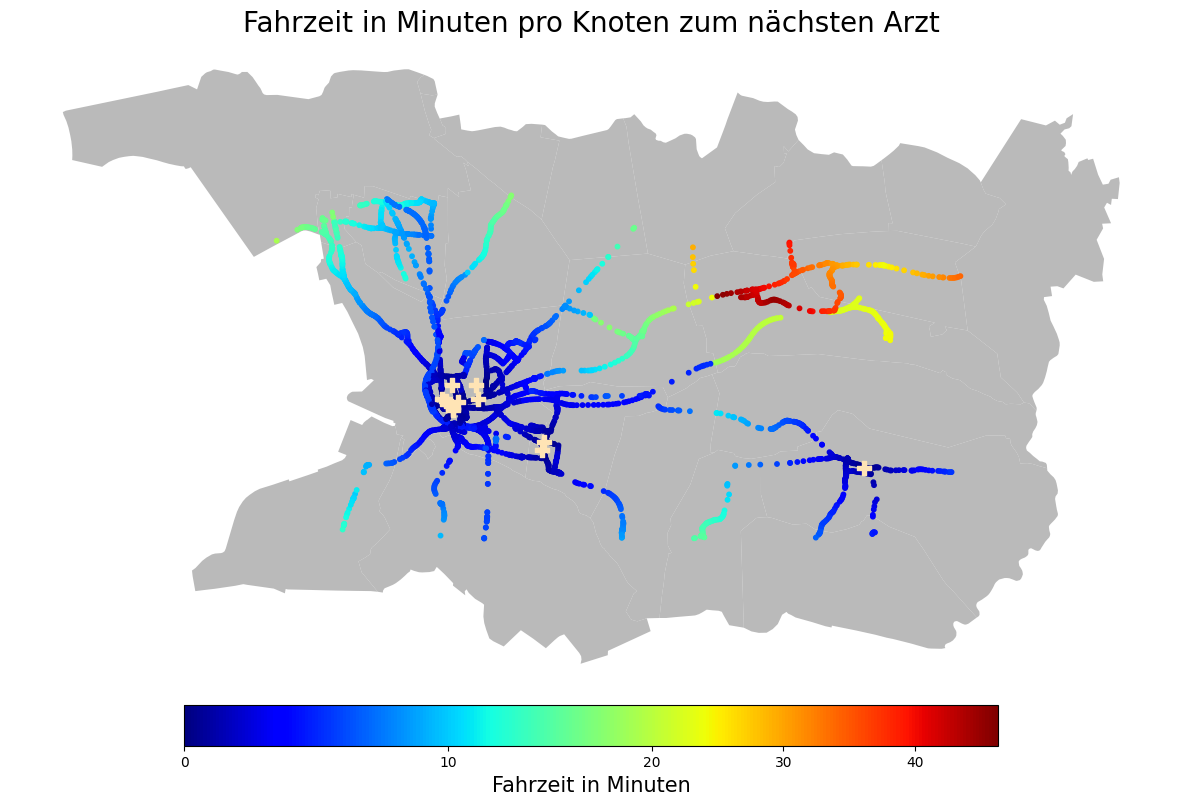

In [28]:
# color scale definieren, indem Minimum und Maximum der travel times genutzt wird
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/3, vmax=max_time_sec)

fig, ax = plt.subplots(1, figsize=(15, 15))
kreise_klein.plot(ax=ax, color='darkgrey',alpha=0.8)
knoten.plot(ax=ax, 
    column="travel_time", cmap="jet", s=10, alpha=1)
plt.scatter(x=point_x, y=point_y, color='moccasin', marker = 'P', s=90)

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal', shrink=0.7, pad=0.01) #pad zum Einstellen des Abstands Bild-Colorbar
cb.set_label('Fahrzeit in Minuten', fontsize = 15)

ax.set_axis_off()
ax.set_title("Fahrzeit in Minuten pro Knoten zum nächsten Arzt", fontsize=20)
plt.show()

## Rastererstellung für die Analyse

Für Analysen sind die Knoten nicht immer ausreichen. Daher wird ein Raster erstellt, was über dem Untersuchungsgebiet liegt. Für das Raster erden alle in der Kachel liegendne Knoten ermittelt. Als Wert wird der Kachel die mittlerer Reisezeit der Knoten zugeordnet.

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Definieren einer Funktion zum Berechnen des Mittelwerts für jede Kachel
def calculate_mean_travel_time(nodes_within_tile):
    # Filtern von NaN-Werte aus der Spalte "travel_time"
    valid_travel_times = nodes_within_tile['travel_time'].dropna()
    # Berechnung des Mittelwerts, wenn Werte vorhanden sind, andernfalls NaN
    return valid_travel_times.mean() if not valid_travel_times.empty else np.nan

# Definieren der Kachelgröße
tile_size = 500  # Meter

# Erstellung eines Rasters über dem Untersuchungsbereich
minx, miny, maxx, maxy = kreise_klein.total_bounds
x_coords = np.arange(minx, maxx, tile_size)
y_coords = np.arange(miny, maxy, tile_size)

# Iterieren  über das Raster und Durchführung der Berechnungen der Werte
results = []
for x in x_coords:
    for y in y_coords:
        # Erstellung eines Quadrats (Polygon) für jede Kachel
        tile_polygon = Point(x, y).buffer(tile_size / 2).envelope #buffer = Kreis mit Radius tilesize/2 und envelop ist eine Geometrie, die dies umhüllt ->BBox mit Kantenlänge radius*2=tilesize
        # Filtern der Knoten, die innerhalb der Kachel liegen
        nodes_within_tile = knoten[knoten.geometry.within(tile_polygon)]
        # Berechnung des Mittelwerts für die Kachel und speichern des Ergebnisses
        mean_travel_time = calculate_mean_travel_time(nodes_within_tile)
        results.append({'tile_geometry': tile_polygon, 'mean_travel_time': mean_travel_time})

# Erstellen einens neuen Geodataframe mit den Ergebnissen
result_gdf = gpd.GeoDataFrame(results, geometry='tile_geometry', crs='epsg:25832')

Optional abspeichern des erstellten Rasters.

In [ ]:
#result_gdf.to_file('./Isochronen/Minimalgraph/IST/Raster500/rastermittraveltim550.geojson', driver='GeoJSON')

Visualisieren des Rasters

In [ ]:
# color scale definieren, indem Minimum und Maximum der travel times genutzt wird
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=max_time_sec/3, vmax=max_time_sec)

fig, ax = plt.subplots(1, figsize=(15, 15))
kreise_klein.plot(ax=ax, color='darkgrey',edgecolor = 'black',alpha=0.8)
result_gdf.plot(ax=ax, column="mean_travel_time", cmap="jet", alpha=1)
knoten.plot(ax=ax, 
    column="travel_time", cmap="jet", s=10, alpha=0)
plt.scatter(x=point_x, y=point_y, color='moccasin', marker = 'P', s=90)

# add colotbat showing travel time and corresponding colour
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap="jet"), 
    ax=ax, orientation='horizontal', shrink=0.7, pad=0.01) #pad zum Einstellen des Abstands Bild-Colorbar
cb.set_label('Fahrzeit in Minuten', fontsize = 15)

ax.set_axis_off()
ax.set_title("Fahrzeit in Minuten pro Knoten zum nächsten Arzt", fontsize=20)
plt.show()